In [1]:
!pip install git+https://github.com/pytorch/vision
!pip install git+https://github.com/fastai/fastai2 
!pip install git+https://github.com/fastai/fastcore
!pip install tf-nightly

  Cloning https://github.com/pytorch/vision to /tmp/pip-req-build-f4b0iclv
  Running command git clone -q https://github.com/pytorch/vision /tmp/pip-req-build-f4b0iclv
  ERROR: Failed building wheel for torchvision
  Running setup.py clean for torchvision
Failed to build torchvision
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101
    Running setup.py install for torchvision ... error
  Rolling back uninstall of torchvision
  Moving to /usr/local/lib/python3.6/dist-packages/torchvision-0.6.1+cu101.dist-info/
   from /usr/local/lib/python3.6/dist-packages/~orchvision-0.6.1+cu101.dist-info
  Moving to /usr/local/lib/python3.6/dist-packages/torchvision/
   from /usr/local/lib/python3.6/dist-packages/~orchvision
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-req-build-f4b0iclv/setup.py'"'"'; __file__='"'

In [2]:
import torchvision
print(torchvision.__version__)

0.7.0


In [3]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

VERSION = "20200325"  #@param ["1.5" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5115  100  5115    0     0  31770      0 --:--:-- --:--:-- --:--:-- 31770
Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200325 ...
     |████████████████████████████▍   | 51kB 3.4MB/s eta 0:00:01Uninstalling torch-1.6.0:
     |████████████████████████████████| 61kB 2.7MB/s 
  Successfully uninstalled torch-1.6.0
ERROR: Error checking for conflicts.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most rec

In [4]:
from fastai2.vision.all import *
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.0-dev20200731


In [5]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

AUTO = tf.data.experimental.AUTOTUNE

IMAGE_SIZE = [331, 331]

batch_size = 16 * tpu_strategy.num_replicas_in_sync

gcs_pattern = 'gs://flowers-public/tfrecords-jpeg-331x331/*.tfrec'
validation_split = 0.19
filenames = tf.io.gfile.glob(gcs_pattern)
split = len(filenames) - int(len(filenames) * validation_split)
train_fns = filenames[:split]
validation_fns = filenames[split:]

def parse_tfrecord(example):
  features = {
    "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
    "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
    "one_hot_class": tf.io.VarLenFeature(tf.float32),
  }
  example = tf.io.parse_single_example(example, features)
  decoded = tf.image.decode_jpeg(example['image'], channels=3)
  normalized = tf.cast(decoded, tf.float32) / 255.0 # convert each 0-255 value to floats in [0, 1] range
  image_tensor = tf.reshape(normalized, [*IMAGE_SIZE, 3])
  one_hot_class = tf.reshape(tf.sparse.to_dense(example['one_hot_class']), [5])
  return image_tensor, one_hot_class

def load_dataset(filenames):
  # Read from TFRecords. For optimal performance, we interleave reads from multiple files.
  records = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  return records.map(parse_tfrecord, num_parallel_calls=AUTO)

Running on TPU  ['10.4.132.122:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.4.132.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.4.132.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
import math, re, os
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.4.0-dev20200726


In [ ]:
# Use this code to load your kaggle.json file, which will have your Kaggle API key
from google.colab import files
files.upload()

In [8]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [15]:
# If this code gives an error, open a flower notebook and run 
# from kaggle_datasets import KaggleDatasets
# GCS_DS_PATH = KaggleDatasets().get_gcs_path() # you can list the bucket with "!gsutil ls $GCS_DS_PATH"
# print(GCS_DS_PATH)
GCS_DS_PATH =r'gs://kds-182916f476f005a843d198583faba1355a71e6c37230237174343373'

IMAGE_SIZE = [331, 331] # At this size, a GPU will run out of memory. Use the TPU.
                        # For GPU training, please select 224 x 224 px image size.
EPOCHS = 12
BATCH_SIZE = 16 * tpu_strategy.num_replicas_in_sync

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102





In [ ]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [ ]:
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
load_dataset(TRAINING_FILENAMES)

<ParallelMapDataset shapes: ((512, 512, 3), ()), types: (tf.float32, tf.int32)>

In [ ]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


In [ ]:
# data dump
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())
print("Validation data shapes:")
for image, label in get_validation_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())
print("Test data shapes:")
for image, idnum in get_test_dataset().take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Training data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Training data label examples: [99 63 81 ... 73 67 55]
Validation data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Validation data label examples: [ 10  49  79 ...  95 103   6]
Test data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Test data IDs: ['b87e16bc0' 'd8437a7f7' '981396649' ... '15cb0c24a' '1c3a7bc99' 'b20b97998']


In [ ]:
# Peek at training data
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

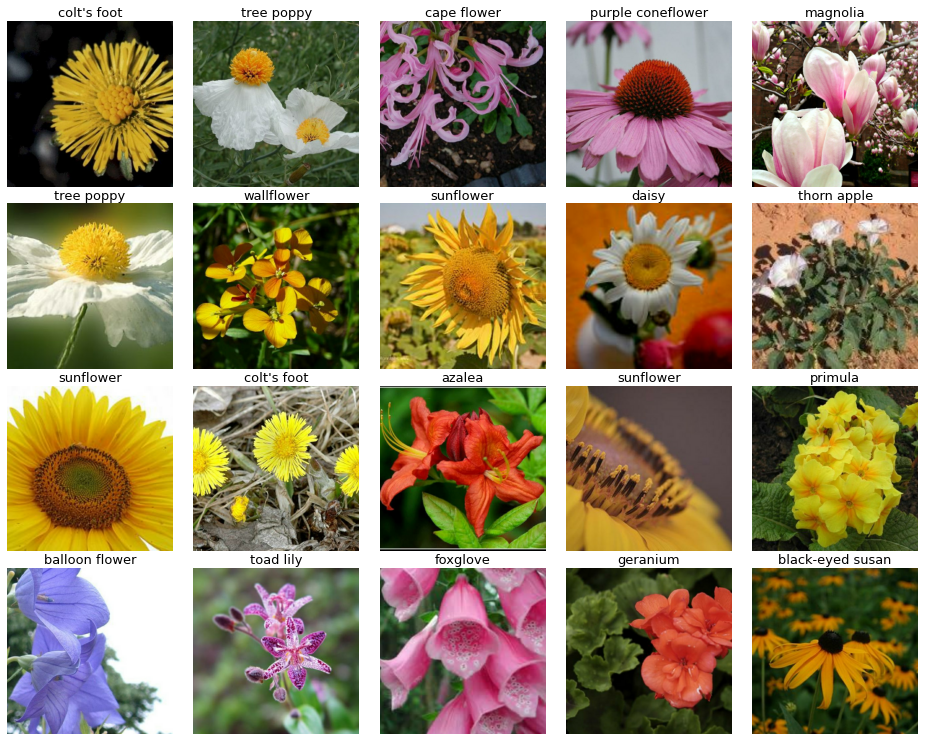

In [ ]:
# run this cell again for next set of images
display_batch_of_images(next(train_batch))

In [ ]:
# peer at test data
test_dataset = get_test_dataset()
test_dataset = test_dataset.unbatch().batch(20)
test_batch = iter(test_dataset)

In [ ]:
help(display_batch_of_images)

Help on function display_batch_of_images in module __main__:

display_batch_of_images(databatch, predictions=None)
    This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)



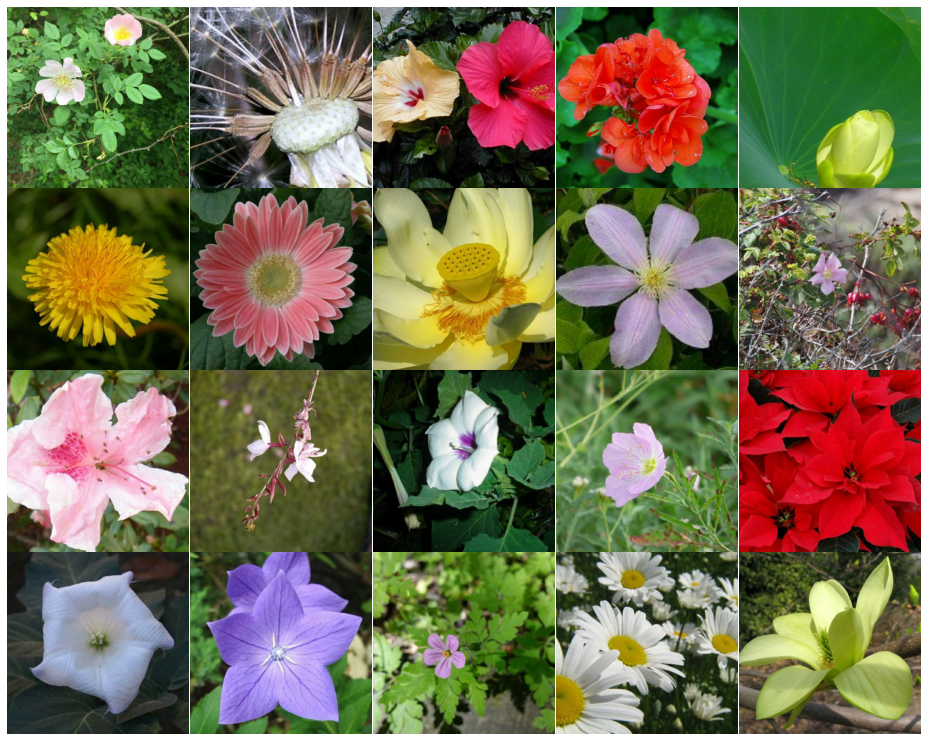

In [ ]:
# run this cell again for next set of images
display_batch_of_images(next(test_batch))

In [ ]:
dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files

dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

<BatchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.string)>

In [ ]:
print(help(ImageDataLoaders.from_dsets))
print(help(ImageDataLoaders.from_name_func))
print(help(ImageDataLoaders.from_lists))
print(help(ImageDataLoaders.from_path_func))

Help on method from_dsets in module fastai2.data.core:

from_dsets(*ds, path='.', bs=64, device=None, dl_type=<class 'fastai2.data.core.TfmdDL'>, **kwargs) method of builtins.type instance

None
Help on method from_name_func in module fastai2.vision.data:

from_name_func(path, fnames, label_func, valid_pct=0.2, seed=None, item_tfms=None, batch_tfms=None, bs=64, val_bs=None, shuffle_train=True, device=None) method of builtins.type instance
    Create from the name attrs of `fnames` in `path`s with `label_func`

None
Help on method from_lists in module fastai2.vision.data:

from_lists(path, fnames, labels, valid_pct=0.2, seed:int=None, y_block=None, item_tfms=None, batch_tfms=None, bs=64, val_bs=None, shuffle_train=True, device=None) method of builtins.type instance
    Create from list of `fnames` and `labels` in `path`

None
Help on method from_path_func in module fastai2.vision.data:

from_path_func(path, fnames, label_func, valid_pct=0.2, seed=None, item_tfms=None, batch_tfms=None, b

In [ ]:
help(get_image_files)

Help on function get_image_files in module fastai2.data.transforms:

get_image_files(path, recurse=True, folders=None)
    Get image files in `path` recursively, only in `folders`, if specified.



In [ ]:
doc(ImageDataLoaders.from_path_func)

ImageDataLoaders.from_path_func(path, fnames, label_func, valid_pct=0.2, seed=None, item_tfms=None, batch_tfms=None, bs=64, val_bs=None, shuffle_train=True, device=None)
Create from list of `fnames` in `path`s with `label_func`

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


<TFRecordDatasetV2 shapes: (), types: tf.string>

In [ ]:
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
print(len(TRAINING_FILENAMES))

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def load_lbl_dataset(filenames, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

load_image=lambda fn:decode_image(read_labeled_tfrecord(load_lbl_dataset(fn))[0])
load_label=lambda fn:read_labeled_tfrecord(load_lbl_dataset(fn))[1]
lbl_from_rec=lambda rec:rec[1]

dls = ImageDataLoaders.from_path_func(GCS_PATH, load_image, valid_pct=0.2, seed=42, label_func=load_label, item_tfms=Resize(224))

16


TypeError: ignored

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.178990,0.040377,0.009472,34:06


epoch,train_loss,valid_loss,error_rate,time
0,0.055877,0.023677,0.007442,50:05


In [ ]:
from fastai2.vision.all import *
doc(cnn_learner)

cnn_learner(dls, arch, loss_func=None, pretrained=True, cut=None, splitter=None, y_range=None, config=None, n_out=None, normalize=True, opt_func=<function Adam at 0x7f889faa9400>, lr=0.001, cbs=None, metrics=None, path=None, model_dir='models', wd=None, wd_bn_bias=False, train_bn=True, moms=(0.95, 0.85, 0.95))
Build a convnet style learner from `dls` and `arch`

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


In [ ]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

learn = unet_learner(dls, resnet34)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,time
0,2.890888,2.171712,01:04


epoch,train_loss,valid_loss,time
0,1.774886,1.303997,01:10
1,1.532316,1.169110,01:10


epoch,train_loss,valid_loss,time
0,1.416416,1.991991,01:07


epoch,train_loss,valid_loss,time
0,1.387626,1.136194,01:09
1,1.246152,0.909927,01:09
2,1.110325,0.783234,01:09
3,1.001200,0.730839,01:09
4,0.909800,0.714955,01:09
5,0.838608,0.693906,01:09


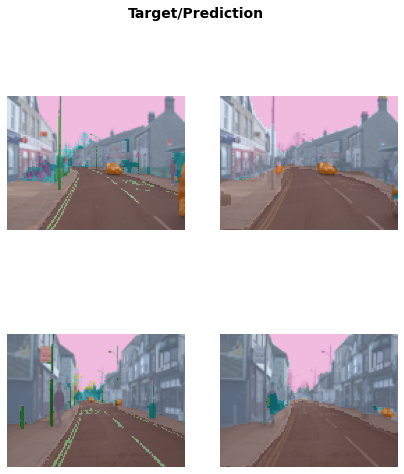

In [ ]:
learn.fine_tune(6)
learn.show_results(max_n=6, figsize=(7,8))

In [ ]:
from fastai2.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.579355,0.398657,0.819200,2:53:55


epoch,train_loss,valid_loss,accuracy,time
0,0.269210,0.224856,0.911120,6:46:29


In [ ]:
learn.predict("I really liked that movie!")

('pos', tensor(1), tensor([0.0285, 0.9715]))

In [ ]:
doc(learn.predict)

Learner.predict(item, rm_type_tfms=None, with_input=False)
Return the prediction on `item`, fully decoded, loss function decoded and probabilities

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


In [ ]:
from fastai2.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation',
                 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

learn = tabular_learner(dls, metrics=accuracy)


In [ ]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.359653,0.373364,0.822482,00:06
1,0.363123,0.361313,0.831849,00:05
2,0.346204,0.356691,0.834152,00:06


In [ ]:
from fastai2.collab import *
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')
learn = collab_learner(dls, y_range=(0.5,5.5))
learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,1.522562,1.406754,00:00


epoch,train_loss,valid_loss,time
0,1.383152,1.351160,00:00
1,1.275915,1.178681,00:00
2,1.042689,0.873421,00:00
3,0.818516,0.727148,00:00
4,0.698201,0.690003,00:00
5,0.644332,0.677176,00:00
6,0.622425,0.671186,00:00
7,0.598944,0.668290,00:00
8,0.601968,0.667218,00:00
9,0.597183,0.667002,00:00


In [ ]:
learn.show_results()

,userId,movieId,rating,rating_pred
0,53.0,14.0,4.5,4.622973
1,4.0,39.0,4.5,3.957715
2,75.0,52.0,5.0,4.032003
3,36.0,19.0,3.0,2.729781
4,28.0,77.0,4.0,3.191305
5,68.0,49.0,3.0,3.972100
6,19.0,23.0,2.0,3.137262
7,44.0,77.0,4.0,4.072456
8,82.0,41.0,5.0,4.105668


1.    Do you need these for deep learning?

·         Lots of math T / F

·         Lots of data T / F

·         Lots of expensive computers T / F

·         A PhD T / F

 

2.    Name five areas where deep learning is now the best in the world.

Computer vision
Recommendation engine,
Sound classification
Natural language processing
many kinds of predictive analysis
 

3.    What was the name of the first device that was based on the principle of the artificial neuron?

The Mark I Perceptron
 

4.    Based on the book of the same name, what are the requirements for "Parallel Distributed Processing"?

A set of processing units
A state of activation
An output function for each unit
A pattern of connectivity among units
A propagation rule for propagating patterns of activities through the network of connectivities
An activation rule for combining the inputs impinging on a unit with the current state of that unit to produce a new level of activation for the unit
A learning rule whereby patterns of connectivity are modified by experience
An environment within which the system must operate
 

5.    What were the two theoretical misunderstandings that held back the field of neural networks?

Failure to recognize that multilayer perceptrons could handle critical mathematical functions
Not understanding the need for more than two layers
 

6.    What is a GPU?

A graphical processing unit, a specialized chip for quickly adding and multiplying numbers
 

7.    Open a notebook and execute a cell containing: 1+1. What happens?

It outputs 2
 

8.    Follow through each cell of the stripped version of the notebook for this chapter. Before executing each cell, guess what will happen.
See above

9.    Complete the Jupyter Notebook online appendix.
See below

10.  Why is it hard to use a traditional computer program to recognize images in a photo?

It is very difficult to explicitly program to the computer what a person or a cat or a dog looks like
 

11.  What did Samuel mean by "Weight Assignment"?

A way for the computer to evaluate the importance of various inputs, what is now called parameters
 

12.  What term do we normally use in deep learning for what Samuel called "Weights"?

A multiplication factor for each of the inputs
 

13.  Draw a picture that summarizes Arthur Samuel's view of a machine learning model



 

 

14.  Why is it hard to understand why a deep learning model makes a particular prediction?

Because the prediction involves
 

15.  What is the name of the theorem that a neural network can solve any mathematical problem to any level of accuracy?

Universal Approximation Theorem

16.  What do you need in order to train a model?

A dataset (divided into training, testing and validation sets), labels, a model architecture and loss function.

17.  How could a feedback loop impact the rollout of a predictive policing model?

If the results of the model are fed back into the model by telling the police where to go, it will produce a feedback loop. Police can only arrest people where they are, so the more often a model sends them to a given location, the more arrests they will make there, thereby encouraging the model to send them there more often.

18.  Do we always have to use 224x224 pixel images with the cat recognition model?

Yes, for historical reasons
 

19.  What is the difference between classification and regression?

Classification predicts a category. Regression predicts a number.
 

20.  What is a validation set? What is a test set? Why do we need them?

21.  What will fastai do if you don't provide a validation set?

fastai will create a validation set with 20% of the data

22.  Can we always use a random sample for a validation set? Why or why not?

We cannot always use a random sample because in some cases data from the training set may “leak” into the validation set
 

23.  What is overfitting? Provide an example.

When the model starts memorizing the training set, at the expense of accuracy in the test and validation set
Example of overfitting

24.  What is a metric? How does it differ to "loss"?

A metric helps humans understand the performance of a given model, while loss is the way a computer measures performance.

25.  How can pretrained models help?

For many problems (such as image recognition and natural language processing), pretrained models provide a headstart in solving the last portion, such as distinguishing cats from dogs or positive and negative movie reviews.

26.  What is the "head" of a model?

The last part of a pretrained model, which is what's being trained.

27.  What kinds of features do the early layers of a CNN find? How about the later layers?

Edges and simple shapes

28.  Are image models only useful for photos?

No. They can even work for abstract representations, such as soudns and user behavior.

29.  What is an "architecture"?

A template for a model

30.  What is segmentation?

Classification of individual pixels in an image

31.  What is y_range used for? When do we need it?

If all results are between a low and a high, this helps the model produce results in that range.

32.  What are "hyperparameters"?

Numbers to help the computer iterate the model to improve performace (training the model)

33.  What's the best way to avoid failures when using AI in an organization?

Understanding what validation and test sets are and how to use them.

In [ ]:
# Import necessary libraries
#from fastai2.vision.all import * 
import matplotlib.pyplot as plt

In [ ]:
from PIL import Image

In [ ]:
a = 1
b = a + 1
c = b + a + 1
d = c + b + a + 1
a, b, c ,d

(1, 2, 4, 8)

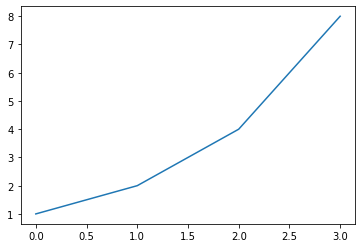

In [ ]:
plt.plot([a,b,c,d])
plt.show()